# **Recoverting history!**

This notebook references the work of [BMnssari](https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python). We will create a classifier for Titanic shipwreck and evaluate it!

<h2> Setting common stuff

In [1]:
import numpy as np 
import pandas as pd 
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# Read CSV train data file into DataFrame
train_df = pd.read_csv("./titanic_train_final.csv")

# Read CSV test data file into DataFrame
test_df = pd.read_csv("./titanic_test_final.csv")

# preview train data
train_df.head()

,Unnamed: 0,PassengerId,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male,IsMinor
0,0,0,0,22.0,7.2500,0,0,0,1,0,0,1,1,0
1,1,1,1,38.0,71.2833,0,1,0,0,1,0,0,0,0
2,2,2,1,26.0,7.9250,1,0,0,1,0,0,1,0,0
3,3,3,1,35.0,53.1000,0,1,0,0,0,0,1,0,0
4,4,4,0,35.0,8.0500,1,0,0,1,0,0,1,1,0


In [3]:
print('The number of samples into the train data is {}.'.format(train_df.shape[0]))

The number of samples into the train data is 891.


In [4]:
# preview test data
test_df.head()

,Unnamed: 0,PassengerId,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male,IsMinor
0,0,0,34.5,7.8292,1,0,0,1,0,1,0,1,0
1,1,1,47.0,7.0000,0,0,0,1,0,0,1,0,0
2,2,2,62.0,9.6875,1,0,1,0,0,1,0,1,0
3,3,3,27.0,8.6625,1,0,0,1,0,0,1,1,0
4,4,4,22.0,12.2875,0,0,0,1,0,0,1,0,0


In [5]:
print('The number of samples into the test data is {}.'.format(test_df.shape[0]))

The number of samples into the test data is 418.


<h2> Logistic Regression and Results

### Feature elimination

Given an external estimator that assigns weights to features, recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. 

As we have many features, we may have collinearity so this tool basically performs cross validation on all different possible models we could have for the number of features specified, only to return the best!

References: <br>
http://scikit-learn.org/stable/modules/feature_selection.html <br>

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

cols = ["Age","Fare","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"] 
X = train_df[cols]
y = train_df['Survived']
model = LogisticRegression(solver='liblinear')
# create the RFE model and select 8 attributes
rfe = RFE(model, 8)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_S', 'Sex_male', 'IsMinor']


### But how many features is the best?

RFECV performs RFE in a cross-validation loop to find the optimal number or the best number of features. 

Optimal number of features: 8
Selected features: ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_S', 'Sex_male', 'IsMinor']


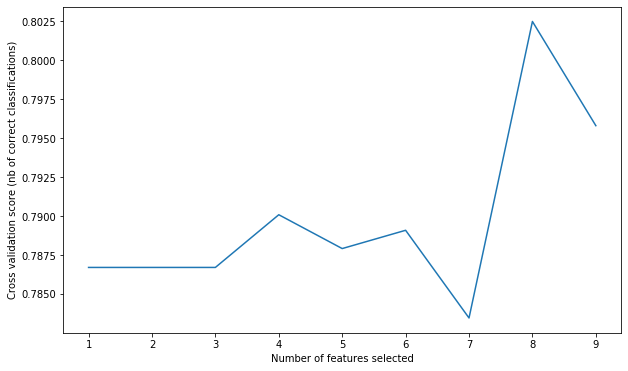

In [7]:
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(solver='liblinear'), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

As we see, eight variables were kept. 

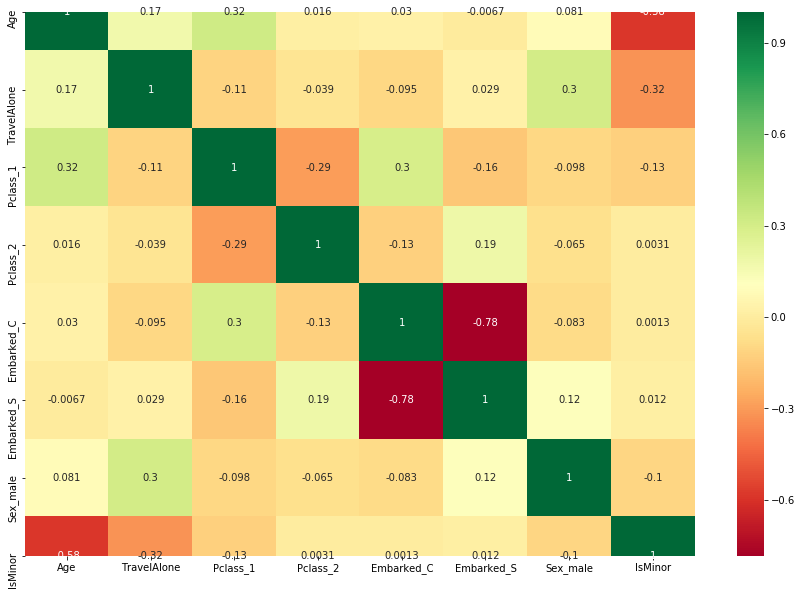

In [8]:
Selected_features = ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 
                     'Embarked_S', 'Sex_male', 'IsMinor']
X = train_df[Selected_features]

plt.subplots(figsize=(15, 10))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

### Optimal threshold

Lets train an out of the box logistic regression to see its performance and lets evaluate which is the best threshold!

Train/Test split results:
LogisticRegression accuracy is 0.782
LogisticRegression log_loss is 0.504
LogisticRegression auc is 0.839


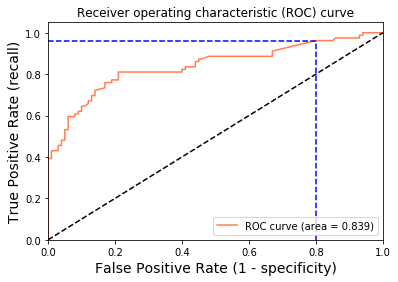

Using a threshold of 0.071 guarantees a sensitivity of 0.962 and a specificity of 0.200, i.e. a false positive rate of 80.00%.


In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

# create X (features) and y (response)
X = train_df[Selected_features]
y = train_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# check classification scores of logistic regression
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

<a id="t4.2.2."></a>
### 4.2.2. Model evaluation based on K-fold cross-validation using `cross_val_score()` function 

In [10]:
# 10-fold cross-validation logistic regression
logreg = LogisticRegression(solver='liblinear')
# Use cross_val_score function
# We are passing the entirety of X and y, not X_train or y_train, it takes care of splitting the data
# cv=10 for 10 folds
# scoring = {'accuracy', 'neg_log_loss', 'roc_auc'} for evaluation metric - althought they are many
scores_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.802
LogisticRegression average log_loss is 0.454
LogisticRegression average auc is 0.850


<a id="t4.3."></a>
## 4.3. GridSearchCV evaluating using multiple scorers simultaneously

best params: LogisticRegression(C=2.8000100000000003, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
best params: {'C': 2.8000100000000003}
best score: 0.8069584736251403


/Users/axelsirota/repos/interpreting-data-with-advanced-models/pluralsight/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


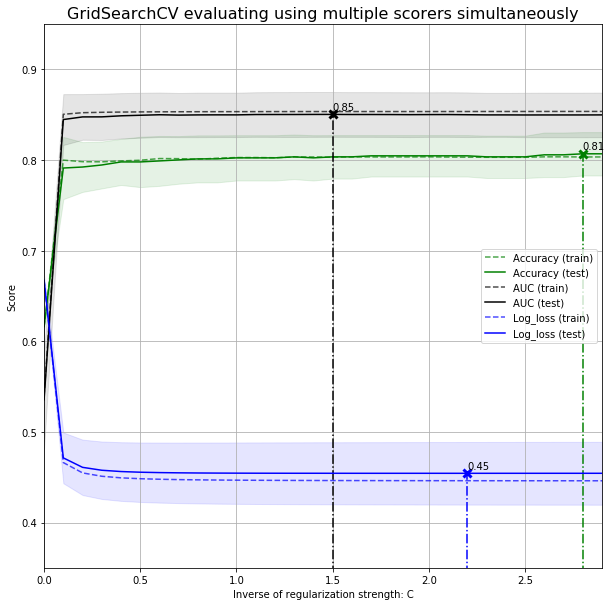

In [11]:
from sklearn.model_selection import GridSearchCV

X = train_df[Selected_features]

param_grid = {'C': np.arange(1e-05, 3, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(solver='liblinear'), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')

gs.fit(X, y)
results = gs.cv_results_

print('='*20)
print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

plt.figure(figsize=(10, 10))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Inverse of regularization strength: C")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, param_grid['C'].max()) 
ax.set_ylim(0.35, 0.95)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

In [12]:
test_df['Survived'] = gs.predict(test_df[Selected_features])

submission = test_df[['PassengerId','Survived']]
submission.tail()

,PassengerId,Survived
413,413,0
414,414,1
415,415,0
416,416,0
417,417,0
